In [363]:
# !py -m pip install pyvista --upgrade
# !py -m pip install ipympl --upgrade
# !py -m pip install trame --upgrade
# !py -m pip install scipy --upgrade
# !py -m pip install imageio --upgrade

In [364]:
import pyvista as pv
import numpy as np

import matplotlib.pyplot as plt
import imageio

from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy import optimize
from scipy.special import comb

from math import sqrt, cos, sin, pi, atan2, degrees

from shapely import affinity, distance
from shapely.geometry import Polygon, Point, LinearRing, LineString, MultiPoint
from shapely.plotting import plot_polygon, plot_points, plot_line
from shapely.ops import transform
from shapely.affinity import rotate

from tqdm.notebook import tqdm

# Functions

In [365]:
def matan(point):
    angle = atan2(point.y, point.x)
    if angle <= 0: angle += 2*pi
    return angle

def norma(point):
    return Point(0,0).distance(point)

def Change(val1, val2):
    val1 = val1 + val2
    val2 = val1 - val2
    val1 = val1 - val2
    return val1, val2

In [366]:
def GetContourFromOBJ(filename):
    return LinearRing(MultiPoint(np.delete(pv.read(filename).project_points_to_plane().points, 2, 1)).convex_hull.boundary.coords)

def Contour2Points(contour, n):
    contour_pts = []
    for i in range(n):
        intersection = contour.intersection(LineString([(0,0), (20*cos((i/n)*2*pi), 20*sin((i/n)*2*pi))]))
        if intersection.geom_type == 'Point':
            contour_pts.append(intersection)
        else:
            contour_pts.append(intersection.geoms[-1])
    return contour_pts

def GetAngleOfRotation(contour_pts, pts, i1, i2):
    angle1, angle2 = matan(Point(pts.geoms[i1].x, pts.geoms[i1].y)), matan(Point(pts.geoms[i2].x, pts.geoms[i2].y))
    i_max, nrm_max = 0, norma(contour_pts[0])
    for i in range(1, len(contour_pts)):
        angle_cur = matan(contour_pts[i])
        if angle1 <= angle_cur and angle_cur <= angle2:
            nrm = norma(contour_pts[i])
            if nrm > nrm_max:
                nrm_max = nrm
                i_max = i
    return matan(contour_pts[i_max])

def RotateListOfPoints(contour_pts, angle):
    rotated_contour_pts = []
    for i in range(len(contour_pts)):
        rotated_contour_pts.append(rotate(contour_pts[i], angle, origin=Point(0.0,0.0), use_radians=True))
    return rotated_contour_pts

def TransformListOfPoints(contour_pts, x_trans, y_trans):
    transformed_contour_pts = []
    for i in range(len(contour_pts)):
        transformed_contour_pts.append(transform(lambda x, y, z=None: (x+(x_trans), y+(y_trans)), contour_pts[i]))
    return transformed_contour_pts

In [367]:
def GetEdgeIndices(rough_pts, pt_min, pt_max):
    angle_min, angle_max = matan(pt_min), matan(pt_max)
    if angle_min >= 2*pi: angle_min -= 2*pi

    for i in range(1, len(rough_pts)):
        if matan(rough_pts[i]) > angle_min:
            i_min = i
            break
    for i in range(1, len(rough_pts)):
        if matan(rough_pts[i]) > angle_max:
            i_max = i-1
            break
    return i_min, i_max

In [368]:
def GetPointOnLineWithDistance(line, distance):
    if distance < 0.0 or distance > line.length:
        return None
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return Point(coords[i][0], coords[i][1])
        if pd > distance:
           return line.interpolate(distance)

def get_bezier_parameters(X, Y, degree=3):
    """ Least square qbezier fit using penrose pseudoinverse.
    Parameters:
    X: array of x data.
    Y: array of y data. Y[0] is the y point for X[0].
    degree: degree of the Bézier curve. 2 for quadratic, 3 for cubic.
    """
    if degree < 1:
        raise ValueError('degree must be 1 or greater.')

    if len(X) != len(Y):
        raise ValueError('X and Y must be of the same length.')

    if len(X) < degree + 1:
        raise ValueError(f'There must be at least {degree + 1} points to '
                         f'determine the parameters of a degree {degree} curve. '
                         f'Got only {len(X)} points.')

    def bpoly(n, t, k):
        return t ** k * (1 - t) ** (n - k) * comb(n, k)
        #return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

    def bmatrix(T):
        return np.matrix([[bpoly(degree, t, k) for k in range(degree + 1)] for t in T])

    def least_square_fit(points, M):
        M_ = np.linalg.pinv(M)
        return M_ * points

    T = np.linspace(0, 1, len(X))
    M = bmatrix(T)
    points = np.array(list(zip(X, Y)))
    
    final = least_square_fit(points, M).tolist()
    final[0] = [X[0], Y[0]]
    final[len(final)-1] = [X[len(X)-1], Y[len(Y)-1]]
    return final

def bernstein_poly(i, n, t):
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

def bezier_curve(points, nTimes):
    pts = []
    for i in range(len(points)):
        pts.append([points[i].x, points[i].y])

    nPoints = len(pts)
    xPoints = np.array([p[0] for p in pts])
    yPoints = np.array([p[1] for p in pts])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    trace_pts = []
    for i in range(nTimes):
        trace_pts.append(Point(xvals[i], yvals[i]))

    return trace_pts

In [433]:
def GetNormals(pts):
    al = []
    for i in range(len(pts)):
        al.append([pts[i].x, pts[i].y])

    a = np.array(al)
    dx_dt = np.gradient(a[:, 0])
    dy_dt = np.gradient(a[:, 1])
    velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])

    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)

    tangent = np.array([1/ds_dt]).transpose() * velocity

    tangent_x = tangent[:, 0]
    tangent_y = tangent[:, 1]

    deriv_tangent_x = np.gradient(tangent_x)
    deriv_tangent_y = np.gradient(tangent_y)

    dT_dt = np.array([ [deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])

    length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)

    normal = np.array([1/length_dT_dt]).transpose() * dT_dt
    normal_pts = []
    for item in normal:
        normal_pts.append(Point(item[0], item[1]))
    return normal_pts
        
def GetCornerIndices(pts, threshold):
    al = []
    for i in range(len(pts)):
        al.append([pts[i].x, pts[i].y])

    a = np.array(al)
    dx_dt = np.gradient(a[:, 0])
    dy_dt = np.gradient(a[:, 1])
    velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])

    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)

    tangent = np.array([1/ds_dt]).transpose() * velocity

    tangent_x = tangent[:, 0]
    tangent_y = tangent[:, 1]

    deriv_tangent_x = np.gradient(tangent_x)
    deriv_tangent_y = np.gradient(tangent_y)

    dT_dt = np.array([ [deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])

    length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)

    normal = np.array([1/length_dT_dt]).transpose() * dT_dt

    d2s_dt2 = np.gradient(ds_dt)
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)

    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
    t_component = np.array([d2s_dt2] * 2).transpose()
    n_component = np.array([curvature * ds_dt * ds_dt] * 2).transpose()

    acceleration = t_component * tangent + n_component * normal

    # plt.plot(curvature)
    return [idx for idx, val in enumerate(curvature) if val>=threshold]

def GetSmoothedContour(pts, threshold):
    n = len(pts)
    indices = GetCornerIndices(pts, threshold)
    iterations = 0
    while len(indices) > 0 and iterations < 1000 and len(pts)==n:
        # print(len(indices))
        bruting_trace_pts = []
        for i in range(len(pts)-1):
            if i not in indices:
                bruting_trace_pts.append(pts[i])
            else:
                pt1 = pts[i-1]
                pt2 = pts[i+1]
                pt = pts[i]
                nrm = norma(pt)
                coeff = (norma(pt1)+norma(pt2))/2
                bruting_trace_pts.append(Point(coeff*pt.x/nrm, coeff*pt.y/nrm))

        pts = bruting_trace_pts
        # mean = GetAverageCurvature(pts)
        indices = GetCornerIndices(pts, threshold)
        # print(len(indices))
        iterations += 1

    if iterations == 1:
        threshold *= 2

    while len(indices) > 0 and iterations < 1000 and len(pts)==n:
        # print(len(indices))
        bruting_trace_pts = []
        for i in range(len(pts)-1):
            if i not in indices:
                bruting_trace_pts.append(pts[i])
            else:
                pt1 = pts[i-1]
                pt2 = pts[i+1]
                pt = pts[i]
                nrm = norma(pt)
                coeff = (norma(pt1)+norma(pt2))/2
                bruting_trace_pts.append(Point(coeff*pt.x/nrm, coeff*pt.y/nrm))

        pts = bruting_trace_pts
        # mean = GetAverageCurvature(pts)
        indices = GetCornerIndices(pts, threshold)
        # print(len(indices))
        iterations += 1
    
    # line = LineString(pts)
    # delta_len = line.length/(n-1)

    # pts = []
    # for i in range(n):
    #     pts.append(GetPointOnLineWithDistance(line, i*delta_len))

    return pts

def GetReversed(pts):
    reversed_pts = []
    for i in reversed(range(len(pts))):
        reversed_pts.append(pts[i])
    return reversed_pts

def CreateDisk(R):
    disk_pts = []
    for i in range(100000):
        angle = (i/100000)*2*pi
        disk_pts.append(Point(R*cos(angle), R*sin(angle)))
    return disk_pts

In [370]:
def GetBrutingTrace(rough_pts, target_pts, step, steps):
    lng = len(rough_pts)

    if step <= steps:
        alpha = step / steps
        bruting_rough_trace_pts = []
        for i in range(lng):
            x1, y1 = rough_pts[i].x, rough_pts[i].y
            x2, y2 = target_pts[i].x, target_pts[i].y
            bruting_rough_trace_pts.append(Point((1-alpha)*x1+alpha*x2, (1-alpha)*y1+alpha*y2))
        
        bruting_trace_pts = []
        for i in range(lng):
            gamma = i / lng
            x1, y1 = rough_pts[i].x, rough_pts[i].y
            x2, y2 = bruting_rough_trace_pts[i].x, bruting_rough_trace_pts[i].y
            bruting_trace_pts.append(Point((1-gamma)*x1+gamma*x2, (1-gamma)*y1+gamma*y2))
        
        # bruting_trace_pts = bruting_rough_trace_pts

        return bruting_trace_pts, bruting_rough_trace_pts
    else:
        bruting_trace_pts = target_pts

        return bruting_trace_pts

def GetParallelOffset(bruting_trace_pts, R):
    normal_vectors = []
    for i in range(len(bruting_trace_pts)-1):
        pt1, pt2 = bruting_trace_pts[i], bruting_trace_pts[i+1]
        x1, y1 = pt1.x, pt1.y
        x2, y2 = pt2.x, pt2.y
        nrm = sqrt((x2-x1)**2+(y2-y1)**2)
        normal_vectors.append(Point(R*(y2-y1)/nrm, -R*(x2-x1)/nrm))
    
    normal_vertices = []
    normal_vertices.append(normal_vectors[0])
    for i in range(len(normal_vectors)-1):
        x = (normal_vectors[i].x+normal_vectors[i+1].x)/2
        y = (normal_vectors[i].y+normal_vectors[i+1].y)/2
        normal_vertices.append(Point(x, y))
    normal_vertices.append(normal_vectors[-1])

    # offset_line = LineString(bruting_trace_pts).parallel_offset(R, 'right', join_style=1)

    # disk_trace_pts = []
    # for pt in bruting_trace_pts:
    #     line = LineString([(pt.x, pt.y), (pt.x+100*normal_vertices[i].x, pt.y+100*normal_vertices[i].y)])
    #     disk_pt = offset_line.intersection(line)
    #     disk_trace_pts.append(disk_pt)

    disk_trace_pts = []
    for i in range(len(bruting_trace_pts)):
        x = bruting_trace_pts[i].x+normal_vertices[i].x
        y = bruting_trace_pts[i].y+normal_vertices[i].y
        disk_trace_pts.append(Point(x, y))

    # return list(MultiPoint(LineString(bruting_trace_pts).parallel_offset(R, 'right', join_style=1).coords).geoms)
    return disk_trace_pts

In [371]:
def GetWholeBrutingTrace(rough_pts, target_pts, steps):
    lng = len(rough_pts)

    step = 1
    alpha = step / steps
    bruting_rough_trace_pts = []
    for i in range(lng):
        x1, y1 = rough_pts[i].x, rough_pts[i].y
        x2, y2 = target_pts[i].x, target_pts[i].y
        bruting_rough_trace_pts.append(Point((1-alpha)*x1+alpha*x2, (1-alpha)*y1+alpha*y2))
    
    bruting_trace_pts = []

    for i in range(lng):
        gamma = i / lng
        x1, y1 = rough_pts[i].x, rough_pts[i].y
        x2, y2 = bruting_rough_trace_pts[i].x, bruting_rough_trace_pts[i].y
        bruting_trace_pts.append(Point((1-gamma)*x1+gamma*x2, (1-gamma)*y1+gamma*y2))

    for i in range(lng):
        gamma = i / lng
        x1, y1 = bruting_rough_trace_pts[i].x, bruting_rough_trace_pts[i].y
        x2, y2 = target_pts[i].x, target_pts[i].y
        bruting_trace_pts.append(Point((1-gamma)*x1+gamma*x2, (1-gamma)*y1+gamma*y2))

    for i in range(lng):
        bruting_trace_pts.append(target_pts[i])

    return bruting_trace_pts

In [425]:
def GetCurrentTrace(trace, angles, disk, R):
    npts = LinearRing(trace).intersection(disk)

    n = len(trace)
    anglec = matan(disk.centroid)
    rc = norma(disk.centroid)

    if npts.geom_type == 'LineString':
        if len(npts.coords) == 0:
            return trace
        angle_edge1 = atan2(npts.coords[0][1], npts.coords[0][0])
        if angle_edge1 < 0: angle_edge1 += 2*pi
        angle_edge2 = atan2(npts.coords[-1][1], npts.coords[-1][0])
        if angle_edge2 < 0: angle_edge2 += 2*pi
    else:
        angle_edge1 = atan2(npts.geoms[-1].coords[0][1], npts.geoms[-1].coords[0][0])
        if angle_edge1 < 0: angle_edge1 += 2*pi
        angle_edge2 = atan2(npts.geoms[0].coords[-1][1], npts.geoms[0].coords[-1][0])
        if angle_edge2 < 0: angle_edge2 += 2*pi

    for i in range(len(angles)):
        if angles[i] >= angle_edge1:
            i_intersect1 = i
            break

    for i in range(len(angles)):
        if angles[i] > angle_edge2:
            i_intersect2 = i
            break

    print((angle_edge1*180/pi, angle_edge2*180/pi), i_intersect1, i_intersect2)

    if i_intersect1 > i_intersect2: 
        for i in range(i_intersect1, n):
            angle_cur = angles[i]
            lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
            trace[i] = Point(lr*cos(angle_cur), lr*sin(angle_cur))
        for i in range(i_intersect2):
            angle_cur = angles[i]
            lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
            trace[i] = Point(lr*cos(angle_cur), lr*sin(angle_cur))
    else:
        for i in range(i_intersect1, i_intersect2):
            angle_cur = angles[i]
            lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
            trace[i] = Point(lr*cos(angle_cur), lr*sin(angle_cur))

    return trace

# Traces Creation

In [439]:
R = 75
n = 10000
baloon_distance = 0.3
r = 2

framerate = 10
if R == 1: size = "small" 
else: size = "big"
# path = "round/whole/" + size + "/rotated/"
path = "whole/"

bruting_traces = []
disk_traces = []
rough_ptss = []

In [440]:
rough   = GetContourFromOBJ("data\\B4969-B_PLANNING_pear\\rough.obj")
pear    = GetContourFromOBJ("data\\B4969-B_PLANNING_pear\\diamond.obj")

baloon_pear = LinearRing(LineString(pear).parallel_offset(baloon_distance, 'left', join_style=2))

rough_pts       = Contour2Points(rough, n)
pear_pts        = Contour2Points(pear, n)
baloon_pear_pts = Contour2Points(baloon_pear, n)

# normals_pts = GetNormals(rough_pts)
intersection_pts0 = rough.intersection(baloon_pear)

rotation_angle = matan(intersection_pts0.geoms[4])

rough = LinearRing(RotateListOfPoints(rough_pts, -rotation_angle))
pear = LinearRing(RotateListOfPoints(pear_pts,  -rotation_angle))
baloon_pear = LinearRing(RotateListOfPoints(baloon_pear_pts, -rotation_angle))

rough_pts       = Contour2Points(rough, n)
pear_pts        = Contour2Points(pear, n)
baloon_pear_pts = Contour2Points(baloon_pear, n)

intersection_pts = rough.intersection(baloon_pear)

swinged_rough_pts = []

# 7, 0, 1, 2, 4, 5, 3, 6

i1, i2 = 7, 0
i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
# print(i_edge_min, i_edge_max)

for i in range(i_edge_min, i_edge_max+1):
    swinged_rough_pts.append(baloon_pear_pts[i])

i1, i2 = 0, 1
i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
# print(i_edge_min, i_edge_max)

for i in range(i_edge_min, i_edge_max+1):
    swinged_rough_pts.append(rough_pts[i])

i1, i2 = 1, 2
i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
# print(i_edge_min, i_edge_max)

for i in range(i_edge_min, i_edge_max+1):
    swinged_rough_pts.append(baloon_pear_pts[i])

i1, i2 = 2, 4
i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
# print(i_edge_min, i_edge_max)

for i in range(i_edge_min, i_edge_max+1):
    swinged_rough_pts.append(rough_pts[i])

i1, i2 = 4, 5
i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
# print(i_edge_min, i_edge_max)

for i in range(i_edge_min, i_edge_max+1):
    swinged_rough_pts.append(baloon_pear_pts[i])

i1, i2 = 5, 3
i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
# print(i_edge_min, i_edge_max)

for i in range(i_edge_min, i_edge_max+1):
    swinged_rough_pts.append(rough_pts[i])

i1, i2 = 3, 6
i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
# print(i_edge_min, i_edge_max)

for i in range(i_edge_min, i_edge_max+1):
    swinged_rough_pts.append(baloon_pear_pts[i])

i_edge_min = i_edge_max
i_edge_max = len(rough_pts)-1
# print(i_edge_min, i_edge_max)

for i in range(i_edge_min, i_edge_max+1):
    swinged_rough_pts.append(rough_pts[i])

angles = []
angles.append(0.0)
for i in range(1, len(swinged_rough_pts)):
    angles.append(matan(swinged_rough_pts[i]))

In [428]:
# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# # plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(swinged_rough_pts, color=(0,0,1), markersize=1, label="swinged rough pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

# print(len(swinged_rough_pts))

# plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.legend()

In [429]:
# steps = 2

# bruting_trace = []
# disk_traces = []

# bruting_trace, rough_bruting_trace = GetBrutingTrace(swinged_rough_pts, pear_pts, 1, steps)
# bruting_traces.append(bruting_trace)
# disk_traces.append(GetParallelOffset(bruting_traces[-1], R))

# bruting_trace, rough_bruting_trace1 = GetBrutingTrace(rough_bruting_trace, pear_pts, 2, steps)
# bruting_traces.append(bruting_trace)
# disk_traces.append(GetParallelOffset(bruting_traces[-1], R))

# bruting_trace = GetBrutingTrace(rough_bruting_trace1, pear_pts, 3, steps)
# bruting_traces.append(bruting_trace)
# disk_traces.append(GetParallelOffset(bruting_traces[-1], R))

In [441]:
steps = 2

bruting_trace = []
disk_traces = []

bruting_traces.append(GetWholeBrutingTrace(swinged_rough_pts, pear_pts, steps))
disk_traces.append(GetParallelOffset(bruting_traces[-1], R))

In [431]:
# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# # plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# # plot_points(swinged_rough_pts, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

# # k = 7950
# # k = 7975
# # k = 7975
# # plot_points(pear_pts[k], color=(1,0,0), markersize=5)
# # plot_points(swinged_rough_pts[k], color=(0,0,1), markersize=5)

# # j = 0
# # k = 5000
# # k = 9999

# # j = 1
# # k = 0

# j = 0
# k = 1000

# plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
# plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

# disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
# plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

# plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

# current_rough_pts = swinged_rough_pts
# for i in tqdm(range(k)):
#     rough_trace = GetCurrentTrace(current_rough_pts, disk, R)
#     current_rough_pts = rough_trace

# # rough_trace = GetTrace(swinged_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
# plot_points(current_rough_pts, color=(0,0,1), markersize=1, label="rough pear")

# # plot_points(rough_bruting_trace1, color=(0,1,0), markersize=1, label="bruting trace")

# plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.legend()

  0%|          | 0/400 [00:00<?, ?it/s]

(0.03608888955361715, 8.048350879567085) 1 223
(1.378457980557204, 8.307020844258448) 38 230
(4.0788909907580875, 8.471260082904148) 113 235
(6.721336942632105, 19.048657588871365) 186 529
(9.480031757470428, 19.377155335594) 263 538
(12.18132062487496, 19.626208166955916) 338 545
(15.707718892095935, 29.099735957206203) 436 808
(17.268054190470178, 29.700069184287276) 479 825
(20.28390100144136, 29.995350031653924) 563 833
(22.985928508118846, 30.221617632132553) 638 839
(24.55126157997112, 39.00520521607582) 681 1083
(28.38804333772478, 39.31797906362311) 788 1092
(31.090320618028993, 39.57210378872728) 863 1099
(32.76425473757123, 46.935667839239585) 910 1303
(35.90697617958798, 47.44289471596174) 997 1317
(40.30466910608501, 53.701361612337145) 1119 1491
(42.682958403649565, 54.05732408530967) 1185 1501
(44.35736689861854, 54.26073376154862) 1232 1507
(47.313994964143674, 59.807276437952055) 1314 1661
(50.32176785469607, 60.23394354739814) 1397 1673
(53.61056168546014, 65.173631674

ValueError: math domain error

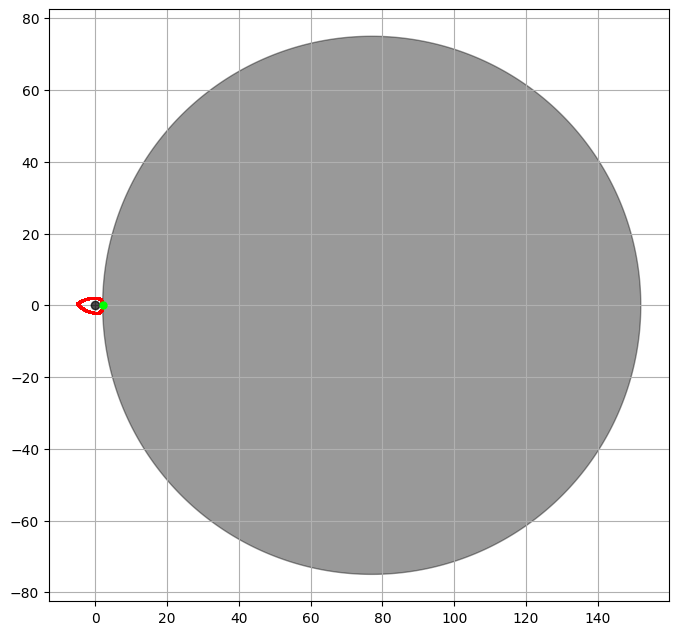

In [437]:
j = 0
count = 797
original_disk = Polygon(CreateDisk(R))

current_rough_pts = swinged_rough_pts
for k in tqdm(range(0, len(bruting_traces[j]), 75)):
    angle = matan(disk_traces[j][k])
    xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x

    plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                color=(1,0,0), markersize=1, label="target pear")
    # plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(baloon_pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
    #         color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
    # plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
    plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

    plot_polygon(transform(lambda x, y, z=None: (x+R+r, y), Polygon(CreateDisk(R))), add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

    # plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(bruting_traces[j]), -angle, origin=Point(0.0,0.0), use_radians=True)), 
    #             color=(0,1,0), markersize=1, label="bruting trace")
    # plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

    disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), original_disk)

    plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                color=(0,1,0), markersize=5, label="touch point")

    # current_rough_pts = swinged_rough_pts if j == 0 else bruting_traces[j-1]
    # rough_trace = GetTrace(current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)

    current_rough_pts = GetCurrentTrace(current_rough_pts, angles, disk, R)
    # current_rough_pts = list(MultiPoint((Polygon(current_rough_pts).difference(disk)).exterior.coords).geoms)
    plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(current_rough_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                color=(0,0,1), markersize=1, label="rough pear")
    
    plt.rcParams["figure.figsize"] = (8.0, 8.0)
    plt.xlim(-7, 7)
    plt.ylim(-6, 6)
    plt.legend()
    plt.savefig(path+"pics/" + str(count) + ".png")
    plt.close()
    count += 1

In [387]:
with imageio.get_writer(path+'movie.gif', mode='I', duration=0) as writer:
    for j in tqdm(range(count)):
        writer.append_data(imageio.v2.imread(path+"pics/" + str(j) + ".png"))

  0%|          | 0/1197 [00:00<?, ?it/s]

In [457]:
xvals = []
rangles = []
dvals = []
time = []

angle0 = matan(intersection_pts0.geoms[4])

whole_length = 0
for trace in disk_traces:
    whole_length = len(trace)

bruting_time = 60.0

cur_length = 0
for j in range(len(disk_traces)):
    with open("round_data/"+str(j)+".txt", 'w') as f:
        for k in range(len(disk_traces[j])):
            cur_length += 1
            xval = R+r-affinity.rotate(disk_traces[j][k], -matan(disk_traces[j][k]), origin=Point(0.0,0.0), use_radians=True).x
            angle = 2*pi-angle0-matan(disk_traces[j][k])
            # while angle < 0.0: angle += 2*pi
            # while angle > 2*pi: angle -= 2*pi
            dval = R+r
            xvals.append(xval)
            rangles.append(angle*180/pi)
            dvals.append(dval)
            time.append(30.0+bruting_time*cur_length/whole_length)
            f.write(str(angle*180/pi) + ' ' + str(xval) + ' ' + str(dval) + '\n')

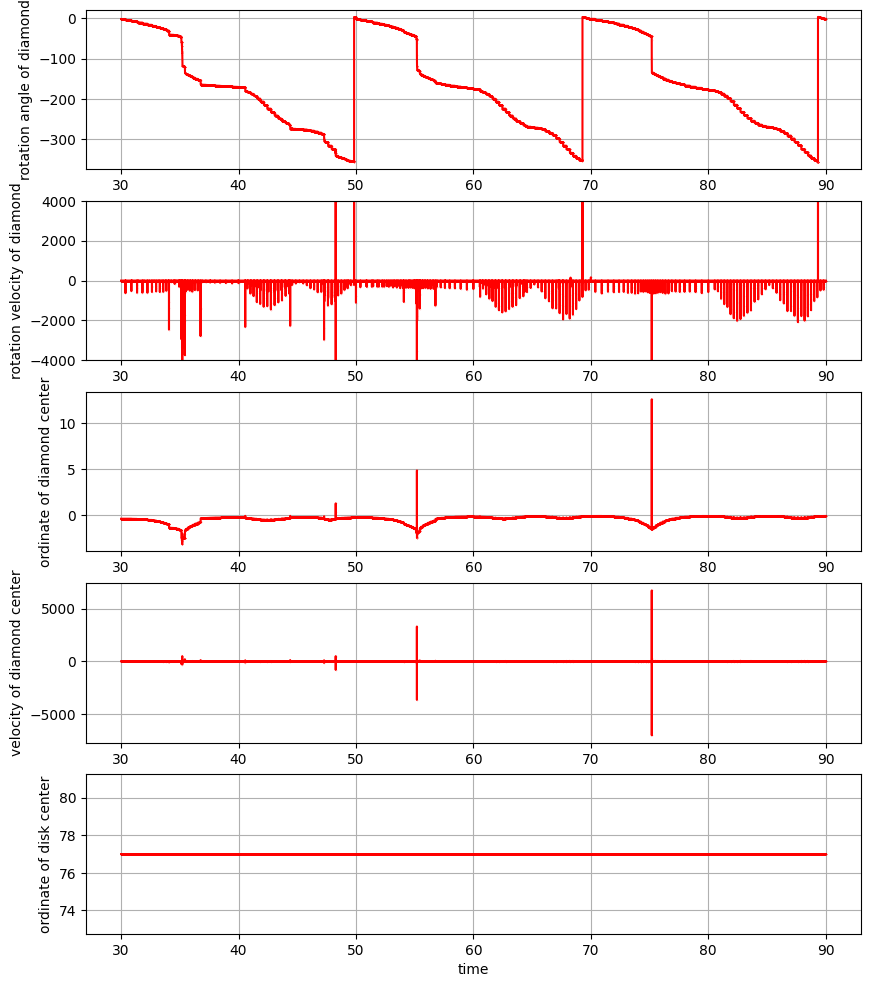

In [458]:
drangles = [(y2-y0)/(x2-x0) for x2, x0, y2, y0 in zip(time[1:], time, rangles[1:], rangles)]
dxvals = [(y2-y0)/(x2-x0) for x2, x0, y2, y0 in zip(time[1:], time, xvals[1:], xvals)]

fig, axs = plt.subplots(5, 1)
fig.set_size_inches(10.0, 12.0)

axs[0].plot(time, rangles, marker='.', color="red", markersize=0.1)
axs[0].set_ylabel('rotation angle of diamond')
axs[0].grid(True)

axs[1].plot(time[:-1], drangles, marker='.', color="red", markersize=0.1)
axs[1].set_ylabel('rotation velocity of diamond')
ylength = 4000
axs[1].set_ylim([-ylength, ylength])
axs[1].grid(True)

axs[2].plot(time, xvals, marker='.', linestyle="-", color="red", markersize=0.1)
axs[2].set_ylabel('ordinate of diamond center')
axs[2].grid(True)

axs[3].plot(time[:-1], dxvals, marker='.', linestyle="-", color="red", markersize=0.1)
axs[3].set_ylabel('velocity of diamond center')
axs[3].grid(True)

axs[4].plot(time, dvals, marker='.', linestyle="-", color="red", markersize=0.1)
axs[4].set_xlabel('time')
axs[4].set_ylabel('ordinate of disk center')
axs[4].grid(True)